In [1]:
!pip install mtcnn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 17.5 MB/s eta 0:00:0000:010:01


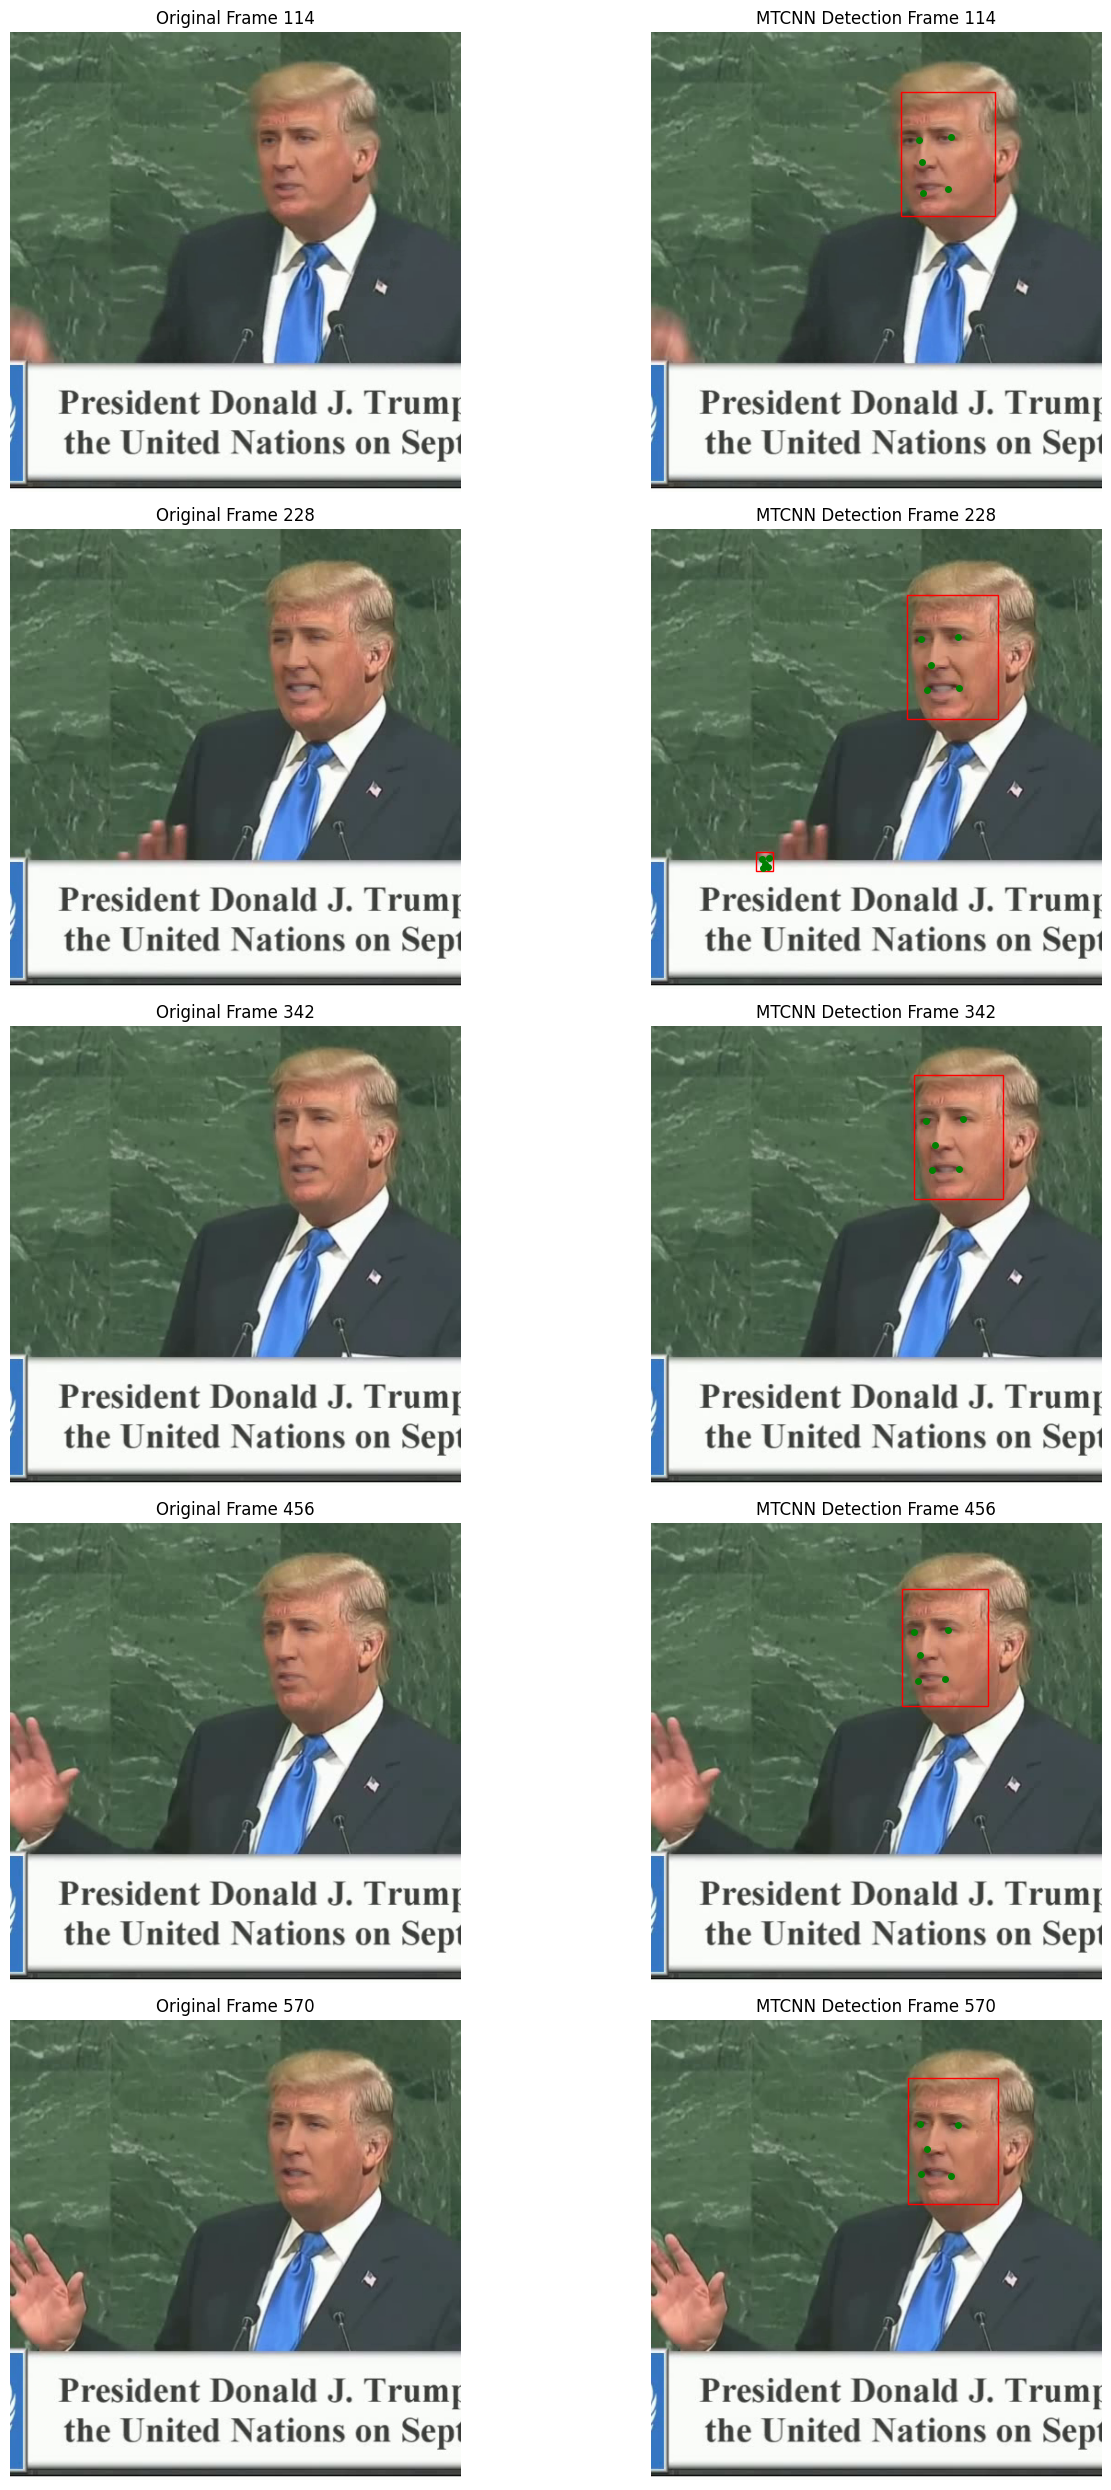

In [2]:
import cv2
import numpy as np
from mtcnn import MTCNN
import matplotlib.pyplot as plt

def visualize_mtcnn_video(video_path, num_frames=5):
    # Initialize MTCNN detector
    detector = MTCNN()

    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Get video properties
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_interval = total_frames // (num_frames + 1)

    # Create a figure with subplots
    fig, axes = plt.subplots(num_frames, 2, figsize=(15, 5*num_frames))

    for i in range(num_frames):
        # Set the frame position
        cap.set(cv2.CAP_PROP_POS_FRAMES, (i + 1) * frame_interval)

        # Read the frame
        ret, frame = cap.read()
        if not ret:
            break

        # Convert frame to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Detect faces
        results = detector.detect_faces(frame_rgb)

        # Plot original frame
        axes[i, 0].imshow(frame_rgb)
        axes[i, 0].set_title(f'Original Frame {(i + 1) * frame_interval}')
        axes[i, 0].axis('off')

        # Plot frame with detections
        axes[i, 1].imshow(frame_rgb)
        axes[i, 1].set_title(f'MTCNN Detection Frame {(i + 1) * frame_interval}')
        axes[i, 1].axis('off')

        # Draw bounding boxes and landmarks
        for result in results:
            bounding_box = result['box']
            keypoints = result['keypoints']

            # Draw rectangle around face
            x, y, w, h = bounding_box
            rect = plt.Rectangle((x, y), w, h, fill=False, color='red')
            axes[i, 1].add_patch(rect)

            # Draw key points
            for keypoint in keypoints.values():
                axes[i, 1].plot(keypoint[0], keypoint[1], 'go', markersize=4)

    # Release the video capture object
    cap.release()

    plt.tight_layout()
    plt.show()

# Example usage
video_path = '/kaggle/input/sample-videos/0046_fake.mp4'
visualize_mtcnn_video(video_path, num_frames=5)


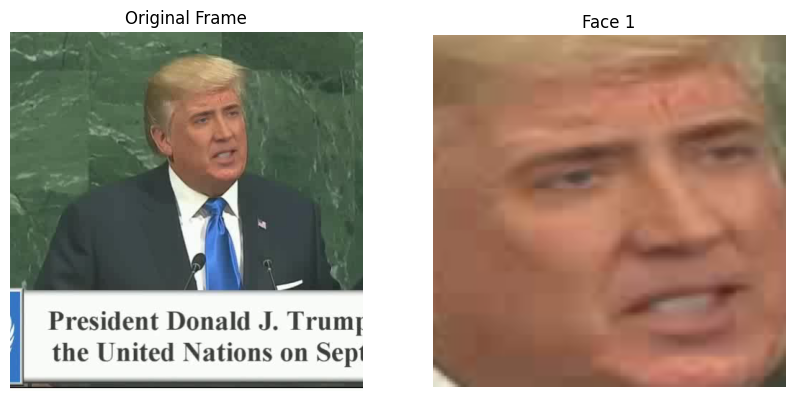

In [3]:
import cv2  
from mtcnn import MTCNN  
import matplotlib.pyplot as plt  

# Initialize MTCNN detector  
detector = MTCNN()  

# Path to the video  
video_path = '/kaggle/input/sample-videos/0046_fake.mp4'  

# Open the video file  
cap = cv2.VideoCapture(video_path)  

# Read the first frame  
ret, frame = cap.read()  

# Check if the frame is read correctly  
if not ret:  
    print("Failed to read the video")  
    cap.release()  
else:  
    # Convert the frame to RGB  
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  

    # Detect faces in the frame  
    results = detector.detect_faces(rgb_frame)  

    # Plot the original frame  
    plt.figure(figsize=(10, 5))  
    plt.subplot(1, len(results) + 1, 1)  
    plt.imshow(rgb_frame)  
    plt.title("Original Frame")  
    plt.axis('off')  

    # Extract, resize, and plot each detected face  
    for i, result in enumerate(results):  
        x, y, width, height = result['box']  
        face = rgb_frame[y:y+height, x:x+width]  

        # Resize the face to 128x128  
        resized_face = cv2.resize(face, (128, 128))  

        plt.subplot(1, len(results) + 1, i + 2)  
        plt.imshow(resized_face)  
        plt.title(f"Face {i+1}")  
        plt.axis('off')  

    plt.show()  

# Release the video capture object  
cap.release()

In [4]:
import cv2
import numpy as np
from mtcnn import MTCNN
import os

# Constants
IMAGE_HEIGHT, IMAGE_WIDTH = 128, 128
SEQUENCE_LENGTH = 21

# Initialize MTCNN
detector = MTCNN()

def extract_and_save_faces(video_path, output_dir, num_frames=SEQUENCE_LENGTH):
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
    
    saved_frames = []
    
    for idx, frame_idx in enumerate(frame_indices):
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        if ret:
            # Convert to RGB (MTCNN expects RGB images)
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            # Detect faces
            faces = detector.detect_faces(rgb_frame)
            
            if faces:
                # Get the first detected face
                x, y, width, height = faces[0]['box']
                face = rgb_frame[y:y+height, x:x+width]
                
                # Resize to model input size
                face_resized = cv2.resize(face, (IMAGE_WIDTH, IMAGE_HEIGHT))
                
                # Save the face image
                output_path = os.path.join(output_dir, f'face_frame_{idx+1}.jpg')
                cv2.imwrite(output_path, cv2.cvtColor(face_resized, cv2.COLOR_RGB2BGR))
                saved_frames.append(output_path)
            else:
                print(f"No face detected in frame {idx+1}")
    
    cap.release()
    return saved_frames

# Paths to your input videos
real_video_path = '/kaggle/input/sample-videos/0046.mp4'
fake_video_path = '/kaggle/input/sample-videos/0046_fake.mp4'

# Output directories for saved faces
real_output_dir = '/kaggle/working/videos/real'
fake_output_dir = '/kaggle/working/videos/fake'

# Extract and save faces for real video
real_saved_face_paths = extract_and_save_faces(real_video_path, real_output_dir)
print(f"Saved {len(real_saved_face_paths)} real face frames to {real_output_dir}")

# Extract and save faces for fake video
fake_saved_face_paths = extract_and_save_faces(fake_video_path, fake_output_dir)
print(f"Saved {len(fake_saved_face_paths)} fake face frames to {fake_output_dir}")

# Function to load face frames
def load_face_frames(frame_paths):
    faces = []
    for path in frame_paths:
        face = cv2.imread(path)
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        faces.append(face)
    return np.array(faces) / 255.0

# Load face frames for real and fake videos
real_input_frames = load_face_frames(real_saved_face_paths)
fake_input_frames = load_face_frames(fake_saved_face_paths)

# Add batch dimension
real_input_frames = np.expand_dims(real_input_frames, axis=0)
fake_input_frames = np.expand_dims(fake_input_frames, axis=0)

print("Real input shape:", real_input_frames.shape)
print("Fake input shape:", fake_input_frames.shape)


No face detected in frame 21
Saved 20 real face frames to /kaggle/working/videos/real
Saved 21 fake face frames to /kaggle/working/videos/fake
Real input shape: (1, 20, 128, 128, 3)
Fake input shape: (1, 21, 128, 128, 3)


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

All layers in the model:
1. input_layer_1 (InputLayer)
2. lambda (Lambda)
3. xception (Functional)
4. global_average_pooling2d (GlobalAveragePooling2D)
5. lambda_1 (Lambda)
6. lstm (LSTM)
7. lstm_1 (LSTM)
8. dense (Dense)
9. batch_normalization_4 (BatchNormalization)
10. dense_1 (Dense)

All layers in the Xception base model:

All layers in the model:
1. input_layer (InputLayer)
2. block1_conv1 (Conv2D)
3. block1_conv1_bn (BatchNormalization)
4. block1_conv1_act (Activation)
5. block1_conv2 (Conv2D)
6. block1_conv2_bn (BatchNormalization)
7. block1_conv2_act (Activation)
8. block2_sepconv1 (SeparableConv2D)
9. block2_sepconv1_bn (BatchNormalization)
10. block2_sepconv2_act (Activation)
11. block2_sepconv2 (SeparableConv2D)
12. block2_sepconv2_bn (BatchNormalization)
13. conv2d (Conv2D)
14. block2_pool (MaxPooling2D)
15. batch_normalization (BatchNormalization)
16. add (Add)
17. block3_sepconv1_act (Activation)
18. block3_sepconv1 (Sep

I0000 00:00:1729418665.514807     102 service.cc:145] XLA service 0x557662dda520 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729418665.514858     102 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


I0000 00:00:1729418668.480828     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

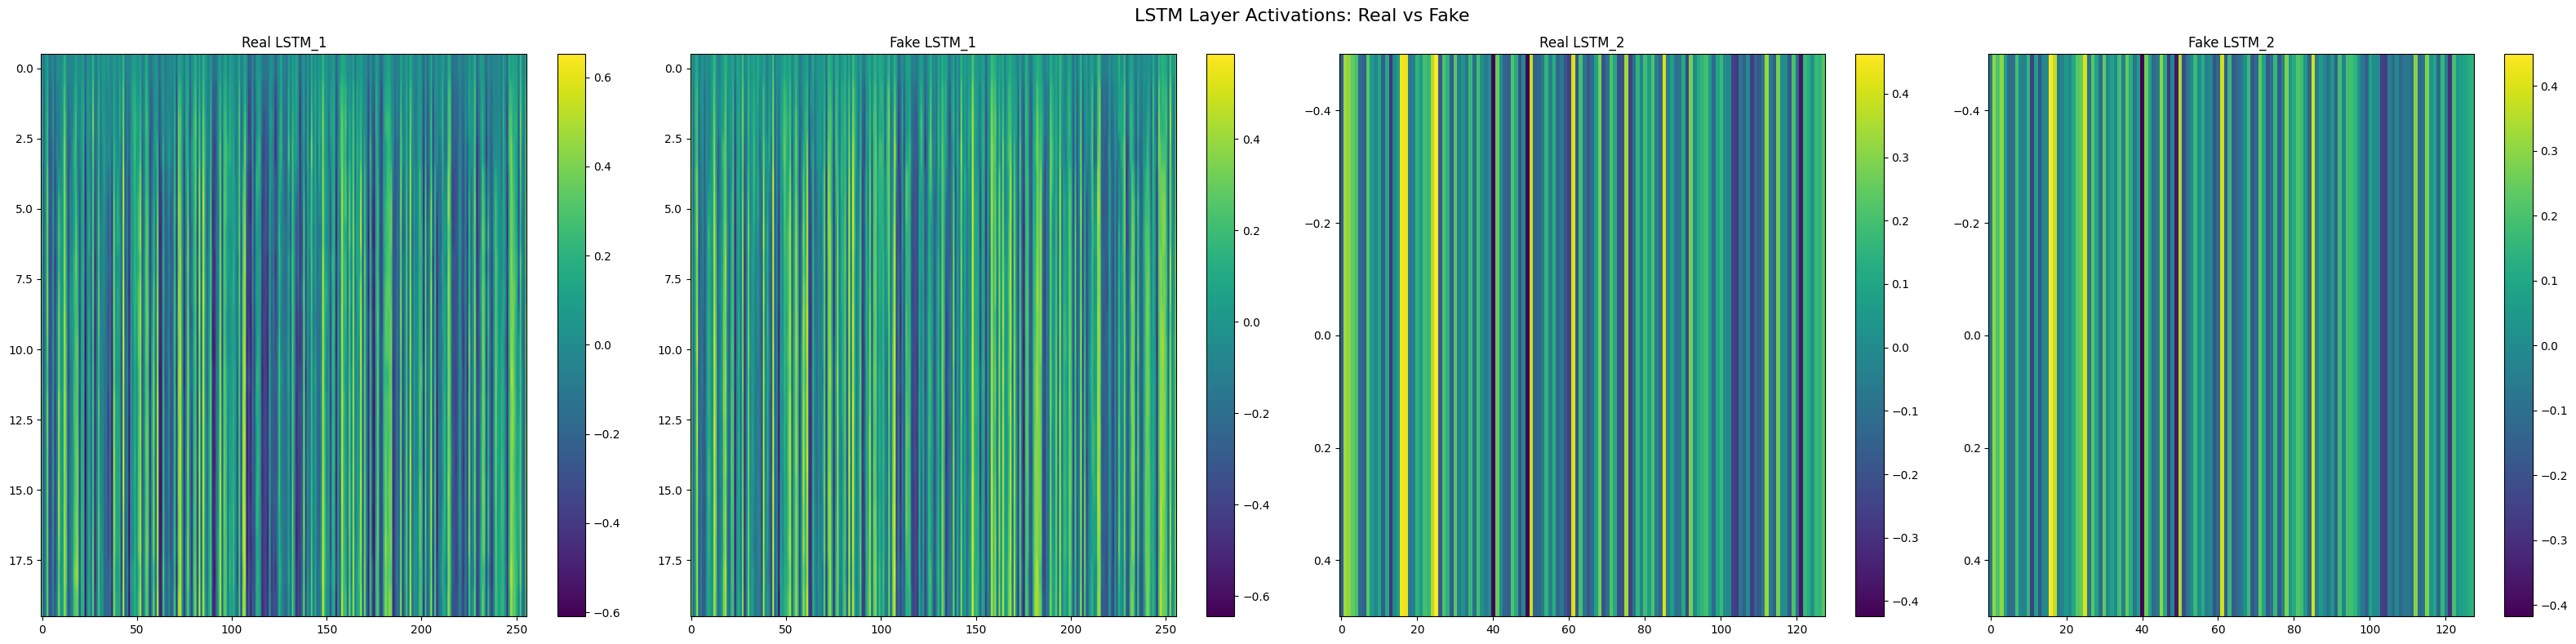

In [5]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, LSTM, Dense, BatchNormalization, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

SEQUENCE_LENGTH = 20
IMAGE_HEIGHT, IMAGE_WIDTH = 128, 128

def create_model():
    # Define input shape
    input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)
    
    # Create Xception base model
    base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Create the model
    inputs = Input(shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    x = tf.keras.layers.Lambda(lambda x: tf.keras.backend.reshape(x, (-1, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))(inputs)
    x = base_model(x)
    x = GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Lambda(lambda x: tf.keras.backend.reshape(x, (-1, SEQUENCE_LENGTH, 2048)))(x)
    
    # LSTM layers
    x = LSTM(256, return_sequences=True)(x)
    x = LSTM(128)(x)
    
    # Dense layers
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    
    # Output layer
    outputs = Dense(1, activation='sigmoid')(x)
    
    # Create and compile the model
    model = Model(inputs=inputs, outputs=outputs)
    optimizer = Adam(learning_rate=1e-4)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model, base_model

def load_face_frames(frame_paths):
    faces = []
    for path in frame_paths:
        if not os.path.exists(path):
            print(f"File not found: {path}")
            continue
        
        face = cv2.imread(path)
        if face is None:
            print(f"Failed to load image: {path}")
            continue
        
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        face = cv2.resize(face, (IMAGE_WIDTH, IMAGE_HEIGHT))
        faces.append(face)
    
    if not faces:
        raise ValueError("No valid images were loaded.")
    
    return np.array(faces) / 255.0

def compare_activations(real_activations, fake_activations, layer_names, title, save_path=None):
    n_layers = len(layer_names)
    n_frames = len(real_activations) if isinstance(real_activations[0], list) else 1
    
    fig, axes = plt.subplots(n_frames, n_layers * 2, figsize=(8*n_layers*2, 8*n_frames))
    fig.suptitle(title, fontsize=16)
    
    if n_frames == 1 and n_layers == 1:
        axes = np.array([[axes]])
    elif n_frames == 1 or n_layers == 1:
        axes = np.expand_dims(axes, axis=0)
    
    for i in range(n_frames):
        for j, layer_name in enumerate(layer_names):
            real_ax = axes[i, j*2]
            fake_ax = axes[i, j*2+1]
            
            if n_frames > 1:
                real_activation = real_activations[i][j]
                fake_activation = fake_activations[i][j]
            else:
                real_activation = real_activations[j]
                fake_activation = fake_activations[j]
            
            if len(real_activation.shape) == 4:  # For convolutional layers
                real_activation = np.squeeze(real_activation, axis=0)
                fake_activation = np.squeeze(fake_activation, axis=0)
                real_im = real_ax.imshow(np.mean(real_activation, axis=-1), cmap='viridis')
                fake_im = fake_ax.imshow(np.mean(fake_activation, axis=-1), cmap='viridis')
            elif len(real_activation.shape) == 3:  # For LSTM layers with timesteps
                real_im = real_ax.imshow(real_activation[0], cmap='viridis', aspect='auto')
                fake_im = fake_ax.imshow(fake_activation[0], cmap='viridis', aspect='auto')
            elif len(real_activation.shape) == 2:  # For LSTM layers without timesteps
                real_im = real_ax.imshow(real_activation, cmap='viridis', aspect='auto')
                fake_im = fake_ax.imshow(fake_activation, cmap='viridis', aspect='auto')
            else:
                raise ValueError(f"Unexpected activation shape: {real_activation.shape}")
            
            real_ax.set_title(f"{'Frame ' + str(i+1) + ', ' if n_frames > 1 else ''}Real {layer_name}")
            fake_ax.set_title(f"{'Frame ' + str(i+1) + ', ' if n_frames > 1 else ''}Fake {layer_name}")
            plt.colorbar(real_im, ax=real_ax)
            plt.colorbar(fake_im, ax=fake_ax)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

# Create the model
model, base_model = create_model()

# Print all layer names
def print_layer_names(model):
    print("\nAll layers in the model:")
    for i, layer in enumerate(model.layers):
        print(f"{i+1}. {layer.name} ({type(layer).__name__})")

print_layer_names(model)

print("\nAll layers in the Xception base model:")
print_layer_names(base_model)

real_saved_face_paths = [f'/kaggle/working/videos/real/face_frame_{i+1}.jpg' for i in range(SEQUENCE_LENGTH)]
fake_saved_face_paths = [f'/kaggle/working/videos/fake/face_frame_{i+1}.jpg' for i in range(SEQUENCE_LENGTH)]

print("Attempting to load real face frames:")
for path in real_saved_face_paths:
    print(f"Checking file: {path}")
    if os.path.exists(path):
        print(f"  File exists: {path}")
    else:
        print(f"  File not found: {path}")

print("\nAttempting to load fake face frames:")
for path in fake_saved_face_paths:
    print(f"Checking file: {path}")
    if os.path.exists(path):
        print(f"  File exists: {path}")
    else:
        print(f"  File not found: {path}")

try:
    real_input_frames = load_face_frames(real_saved_face_paths)
    fake_input_frames = load_face_frames(fake_saved_face_paths)

    real_input_frames = np.expand_dims(real_input_frames, axis=0)
    fake_input_frames = np.expand_dims(fake_input_frames, axis=0)

    # Define layers to visualize
    xception_layers = ['block2_sepconv2_act', 'block5_sepconv3', 'block14_sepconv2']  # Entry, Middle, Exit flow

    # Create visualization models
    xception_vis_model = Model(inputs=base_model.input, outputs=[base_model.get_layer(name).output for name in xception_layers])

    # Get LSTM layers
    lstm_layers = [layer for layer in model.layers if isinstance(layer, LSTM)]

    lstm_vis_model = Model(inputs=model.input, outputs=[layer.output for layer in lstm_layers])

    # Get activations for both real and fake frames
    real_xception_activations = []
    fake_xception_activations = []
    for i in range(SEQUENCE_LENGTH):
        real_xception_activations.append(xception_vis_model.predict(real_input_frames[0, i:i+1]))
        fake_xception_activations.append(xception_vis_model.predict(fake_input_frames[0, i:i+1]))

    real_lstm_activations = lstm_vis_model.predict(real_input_frames)
    fake_lstm_activations = lstm_vis_model.predict(fake_input_frames)

    # Visualize and compare Xception activations
    compare_activations(real_xception_activations, fake_xception_activations, xception_layers, "Xception Layer Activations: Real vs Fake", save_path="xception_activations.png")

    # Visualize and compare LSTM activations
    lstm_layer_names = [f"LSTM_{i+1}" for i in range(len(lstm_layers))]
    compare_activations(real_lstm_activations, fake_lstm_activations, lstm_layer_names, "LSTM Layer Activations: Real vs Fake", save_path="lstm_activations.png")

except ValueError as e:
    print(f"Error: {str(e)}")
except Exception as e:
    print(f"An unexpected error occurred: {str(e)}")
